# Face Mask Detection with Ensemble Learning in PyTorch

## Angel Sarmiento





### Introduction

This computer vision project corresponds to a kaggle dataset called the Face Mask detection dataset. It is a dataset of photos that include people with different face masks and other without face masks. 


### Problem Description

In recent trend in worldwide Lockdowns due to COVID19 outbreak, as Face Mask is becoming mandatory for everyone while roaming outside, approach of Deep Learning for Detecting Faces With and Without mask were a good trendy practice.


### Goals

The goal is to construct bounding boxes around faces in images that discern between face masks and no face masks. For this I will be using transfer learning with ResNet-50, as well as MTCNN for constructing bounding boxes in images and videos.


In [61]:

# This was originally a program I implemented in Google Colab, but my machine has a faster GPU than what is offered on Google Colab so I decided to implement it locally
#from google.colab import drive
#drive.mount('/content/drive')

In [62]:
# Importing Libraries

import torch
import torchvision
from torchsummary import summary
from os import listdir
from PIL import Image, ImageDraw

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models 
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import random

from facenet_pytorch import MTCNN

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from IPython import display

import pandas as pd

import mmcv, cv2

# This is absolutely necessary to pull models from torchvision
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [63]:
# setting the directory for the data

images_directory = os.path.join('face-mask-detection-dataset/Medical mask/images')
train = pd.read_csv(os.path.join("train.csv"))

listdir()

['detections',
 'face-mask-detection-dataset',
 'mask-classification.ipynb',
 'model',
 'new.csv',
 'out_results.csv',
 'submission.csv',
 'train.csv',
 'video.mp4',
 'video_images',
 '__pycache__']

In [64]:
train=train[train.classname.str.contains("face_with_mask$|face_no_mask")] # filtering the data to mask and no mask bales


from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
train["labels"]=lbl.fit_transform(train.classname)
train.to_csv("new.csv", header=True, index=False)
train_new=pd.read_csv("./new.csv")

train_new

,name,x1,x2,y1,y2,classname,labels
0,2756.png,69,126,294,392,face_with_mask,1
1,2756.png,505,10,723,283,face_with_mask,1
2,6098.jpg,360,85,728,653,face_no_mask,0
3,4591.png,239,9,522,342,face_with_mask,1
4,5525.jpg,262,18,484,319,face_no_mask,0
...,...,...,...,...,...,...,...
5744,4149.png,399,71,718,581,face_with_mask,1
5745,3389.png,101,2,435,456,face_with_mask,1
5746,2460.png,650,5,805,184,face_no_mask,0
5747,1894.jpg,437,121,907,644,face_with_mask,1


In [65]:
# defining training set sizes and testing set sizes
train_size = int(len(train_new)*0.8)
test_size = int(len(train_new))-train_size

In [66]:
# Image Label class
class ImageLabel(Dataset): 
    def __init__(self,dataframe,root_dir,transform=None):
        self.annotation=dataframe
        self.root_dir=root_dir
        self.transform=transform
        
    def __len__(self):
        return len(self.annotation)
    
    def __getitem__(self,index):
        img_path=os.path.join(self.root_dir, self.annotation.iloc[index,0])
        new_img=Image.open(img_path).crop((self.annotation.iloc[index,1:5]))
        label=torch.tensor(int(self.annotation.iloc[index,6:7]))
    
        if self.transform:
            image=self.transform(new_img)
            return(image,label)

## GPU Training Setup

In [67]:
# setting some parameters
n_epochs = 5

# seed for reproducability
random_seed = 1
torch.manual_seed(random_seed)

# setting up GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Training and Test Split

In [68]:
# getting a set of augmentations to apply to the images
train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize((128, 128)),
        transforms.RandomCrop((128, 128)),
        transforms.ToTensor()
])

# getting the training data and setting up a train loader
dataset = ImageLabel(dataframe = train_new, root_dir = images_directory, transform = train_transforms)

# Splitting the dataset
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Training and test loaders
train_loader = DataLoader(dataset = trainset, batch_size = 24, shuffle=True)
test_loader = DataLoader(dataset = testset, batch_size = 24, shuffle=True)

# setting up the iteration
dataiter = iter(train_loader)
images, labels = dataiter.next()
images=images.numpy()


## Pre-Trained Model for Transfer Learning

The model chosen here will be ResNet34. A model pretrained using ImageNet data. This CNN has about 34 layers, but is not the only way I will train this model. 
I have decided to add two extra fully connected layers to the end, the first one with **ReLU** activation and the final one as a LogSoftmax layer. The optimizer chosen is **Adam** and the loss function chosen here is Negative Log Likelihood. The main reason for this decision is that I would need to add another layer in order to use Softmax and Cross Entropy cost instead.  

In [69]:
model = models.resnet34(pretrained = True)

In [70]:
# this is to 'freeze' the ResNet part of my model, since its already been trained
for param in model.parameters():
    param.requires_grad = False

# Adding the last layer to identify the two classes
n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,2)
model.fc.out_features=last_layer

# setting the loss function                                 
criterion = nn.CrossEntropyLoss()
# setting the optimizer as Adam
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [71]:
# creating a bunch of lists so that I can append the values and use them for plotting 
epoch_num, train_accuracy, test_accuracy, train_loss_list, val_loss_list = [], [], [], [], []

## Training loop

This is just the typical training loop. This takes a **long** time, even with gpu training. It adds values to previously created lists, so that they can be used for plotting accuracy over successive epochs.

In [72]:
for param in model.parameters():
    param.requires_grad=True

In [60]:
# training loop 
def train_model(model, criterion, optimizer):
    for epoch in range(n_epochs): 
        train_loss = 0
        val_loss = 0
        accuracy = 0

        #actual training
        model.train()
        counter = 0
        # Train Loop
        for inputs, labels in train_loader:
            
            #gpu training
            inputs, labels = inputs.to(device), labels.to(device)

            #zeroing the gradients
            optimizer.zero_grad()

            #forward
            output = model.forward(inputs)
            #loss 
            loss = criterion(output, labels)
            
            # backprop and adjusting parameters from gradient calculations
            loss.backward()
            optimizer.step()

            #adding loss to the lists
            train_loss += loss.item()*inputs.size(0)
            counter += 1
            #print(counter, '/', len(train_loader))
        # evaluating the model
        model.eval()
        counter = 0

        # Test Loop
        #telling torch not to calculate the gradients and make no optimizer steps
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                output = model.forward(inputs)
                #val loss calculation
                val = criterion(output, labels)

                #adding it to the existing loss
                val_loss += val.item()*inputs.size(0)
                #getting the real percentage by reversing the logsoftmax in the final output layer
                output = torch.exp(output)
                # getting the class with the highest probability from the output
                top_p, top_class = output.topk(1, dim=1)
                # which ones were correct
                correct = top_class == labels.view(*top_class.shape)

                #get the mean for each batch
                accuracy += torch.mean(correct.type(torch.FloatTensor)).item()
                counter +=1

                #print(counter, '/', len(test_loader))

        #appending to lists
        train_loss = train_loss/len(train_loader.dataset)
        train_loss_list.append(train_loss)
        valid_l = val_loss/len(test_loader.dataset)
        val_loss_list.append(valid_l)
        train_acc = accuracy/len(train_loader)
        train_accuracy.append(train_acc)
        test_acc = accuracy/len(test_loader)
        test_accuracy.append(test_acc)
        epoch_num.append(epoch)

        print(f'Epoch: {epoch}, Accuracy: {test_acc}, Train loss: {train_loss}, Valid loss: {valid_l}')



In [ ]:
# Training
train_model(model)

In [17]:
# Saving the final results to a csv

import csv

results_list = [epoch_num, train_loss_list, val_loss_list, train_accuracy, test_accuracy]


with open("out_results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results_list)

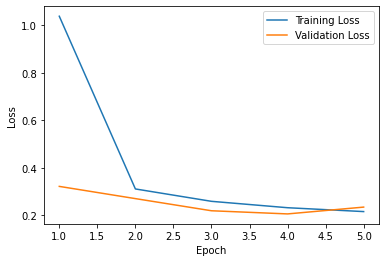

In [18]:
epochs = range(1, len(train_accuracy) + 1)

#plotting the loss 
plt.plot(epochs, train_loss_list, label = 'Training Loss')
plt.plot(epochs, val_loss_list, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 1.0, 'Testing Accuracy of the CNN')

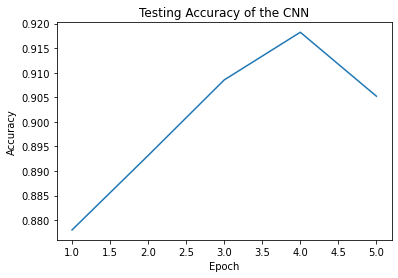

In [19]:
plt.plot(epochs, test_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy of the CNN')

In [20]:
# What was the max accuracy?
print('The Maximum accuracy obtained was: ', max(test_accuracy), 'in Epoch: ', epoch_num[test_accuracy.index(max(test_accuracy))])

The Maximum accuracy obtained was:  0.9182449479897817 in Epoch:  3


In [9]:
# Saving the model for later use (This ends the nightmare of having to train again)
saved_parameters = torch.save(model.state_dict(), 'model/model_params.pth')
saved_model = torch.save(model, 'model/model-final.pth')


NameError: name 'model' is not defined

## Showing off the bounding boxes

In [9]:
from facenet_pytorch import MTCNN
mtcnn = MTCNN(post_process=False, device = device)

In [10]:
model = torch.load('model/model-final.pth')


In [11]:
#image tagging object
# Pulled from someone online. Genius class for mapping the bounding boxes onto the faces.
class TagImages():
    def __init__(self):
        
        self.filepath=filepath
        img=Image.open(self.filepath)
        boxes, _ = mtcnn.detect(img)
    
        predictions=[]
        for i in boxes:
            im_pr=img.crop(i)
            predict_im=train_transforms(im_pr).unsqueeze(0)
            output=model(predict_im.cuda())
            _,pred=torch.max(output,1)
            predicted=pred.numpy() if not torch.cuda.is_available() else pred.cpu().numpy()
            predictions.append(predicted[0])
        self.boxes=boxes
        self.predictions=predictions
        
        # Method for drawing the box
    def draw_box_predicted(self,filepath):
        img=plt.imread(self.filepath)
        fig,ax=plt.subplots(1)
        fig.set_size_inches(10,5)
        ax.imshow(img)
        ax.axis('off')
        configuration=["face_no_mask", "face_with_mask"]
        color={"face_no_mask":"r","face_with_mask":"b"}
        for i,j in zip(self.boxes,self.predictions):
            a,b,c,d=i
            patch=patches.Rectangle((a,b),c-a,d-b,linewidth=2, 
                                    edgecolor=color[configuration[j]],facecolor="none",)
            ax.text(a, b, configuration[j],
                    style='italic',bbox={'facecolor': color[configuration[j]], 'alpha': 0.2, 'pad': 10})
            ax.add_patch(patch)

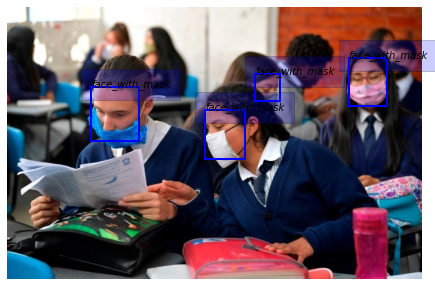

In [46]:
filepath = os.path.join(images_directory, random.choice(train.name.values))
TagImages().draw_box_predicted(filepath)


## Using an ensemble method

In this section, I will be demonstrating an ensemble model consisting of three different models. These are ResNet-50, ResNet-34, SSD (from Nvidia). 

In [82]:
# Custom Ensemble Class
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        
        # Remove last linear layer
        self.modelA.fc = nn.Identity()
        self.modelB.fc = nn.Identity()
        
        # Create new classifier
        self.classifier = nn.Linear(512+512, 2)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)
        
        x = self.classifier(F.relu(x))
        return x

# Training the separate models
# ...
# Using the pretrained torchvision models here
modelA = models.resnet50(pretrained=True)
modelB = models.resnet18(pretrained=True)

# Freezing these models
for param in modelA.parameters():
    param.requires_grad_(False)

for param in modelB.parameters():
    param.requires_grad_(False)

model_ensemble = MyEnsemble(model, modelB)
model_ensemble.to(device)

MyEnsemble(
  (modelA): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [83]:
# setting the loss function                                 
criterion1 = nn.CrossEntropyLoss()
# setting the optimizer as Adam
optimizer1 = optim.Adam(model_ensemble.classifier.parameters(), lr=0.001)

train_model(model_ensemble, criterion=criterion1, optimizer=optimizer1)

Epoch: 0, Accuracy: 0.9200599752366543, Train loss: 0.26904282268362734, Valid loss: 0.17759329744007277
Epoch: 1, Accuracy: 0.9381313100457191, Train loss: 0.19701771909554489, Valid loss: 0.1470250273398731
Epoch: 2, Accuracy: 0.9401041641831398, Train loss: 0.19415306475375574, Valid loss: 0.1486045241161533
Epoch: 3, Accuracy: 0.9366319427887598, Train loss: 0.1829781339534808, Valid loss: 0.14567898049302724
Epoch: 4, Accuracy: 0.9364741158982118, Train loss: 0.17808316907051414, Valid loss: 0.14689655728962112


In [85]:
import csv

# Writing the results
results_list = [epoch_num, train_loss_list, val_loss_list, train_accuracy, test_accuracy]


with open("out_ensemble_results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results_list)

## Results

The first model performs extremely well on the validation data with a loss of approximately 0.2 over only 5 epochs. It also hovers around 90% accuracy over the entire training time. This is a pretty amazing result and I am pretty proud of all of the different ideas that I took from other places/other people's work. The data is available in the csv saved above, and the model parameters as well as the model itself is saved below. The image above shows that the bounding boxes work well. 

The model ensemble does not perform nearly as well. This could be due to the model not converging properly, or something more specific that I cannot see at the moment. It averages at an accuracy of around    and a Validation Loss of about    .

The other plan for this project was to build this classifier into face mask detection for videos. 
